<a href="https://colab.research.google.com/github/GauravKanwat/DL-CS6910-Assignment-2/blob/main/CS6910_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [ ]:
dataset_path = 'drive/MyDrive/CS6910_Assignment_2/inaturalist_12K/'

In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [ ]:
train_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=transform)
val_dataset = datasets.ImageFolder(root = dataset_path + "val", transform=transform)

In [ ]:
# train_dataset = datasets.ImageFolder(root = dataset_path + "train")
# val_dataset = datasets.ImageFolder(root = dataset_path + "val")

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
num_batches = len(train_loader)
print("Number of batches in train_loader:", num_batches)

Number of batches in train_loader: 313


In [ ]:
print(len(train_dataset))

9999


In [ ]:
batch_size = train_loader.batch_size
total_samples = num_batches * batch_size
print("Total number of samples in train_loader:", total_samples)

Total number of samples in train_loader: 10016


In [ ]:
# class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
classpath = pathlib.Path(dataset_path + "train")
# class_names = sorted([j.name.split('/')[-1] for j in classpath.iterdir() if j.name != '.DS_Store'])
class_names = sorted([j.name.split('/')[-1] for j in classpath.iterdir()])

In [ ]:
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [ ]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(6, 6, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Transpose the image tensor to (height, width, channels) for displaying
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()

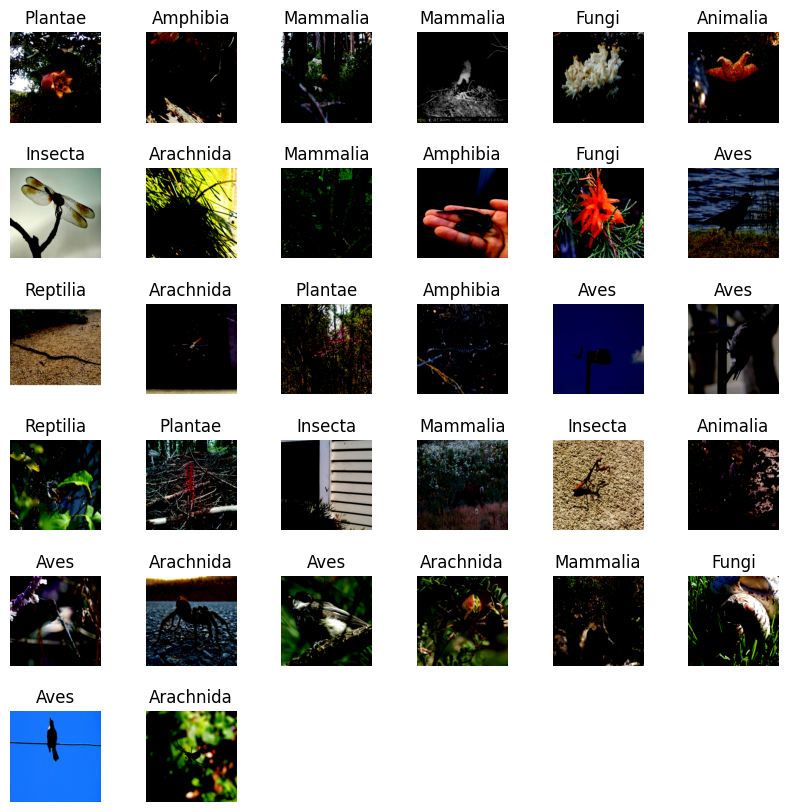

In [ ]:
for images, labels in train_loader:
  show_images(images, labels)
  break

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class SmallCNN(nn.Module):
  def __init__(self, num_classes):
    super(SmallCNN, self).__init__()

    # Defining convolution layers

    # input: 3 x 256 x 256
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    # no. of parameters: 3 x 3 x 3 x 16 = 432

    # after applying maxpooling: input: 16 x 128 x 128
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    # no. of parameters: 16 x 3 x 3 x 32 = 4,608

    # after applying maxpooling: input: 32 x 64 x 64
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # no. of parameters: 32 x 3 x 3 x 64 = 18,432

    # after applying maxpooling: input: 64 x 32 x 32
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    # no. of parameters: 64 x 3 x 3 x 128 = 73,728

    # after applying maxpooling: input: 128 x 16 x 16
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    # no. of parameters: 128 x 3 x 3 x 256 = 2,94,912

    # Defining maxpooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully connected layer
    self.fc1 = nn.Linear(256 * 8 * 8, 512)              # The final maxpooling will give the output as 256 * 8 * 8 where D = 256, W = 8, H = 8
    # no. of parameters: (256 * 8 * 8 * 512) + 512 = 8389120

    self.fc2 = nn.Linear(512, num_classes)
    # no. of parameters: (512 * 10) + 10 = 5130


  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = self.pool(nn.functional.relu(self.conv3(x)))
    x = self.pool(nn.functional.relu(self.conv4(x)))
    x = self.pool(nn.functional.relu(self.conv5(x)))

    x = x.view(-1, 256 * 8 * 8)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
model = SmallCNN(num_classes=10)

SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

  0%|          | 0/1 [02:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to training mode
model.train()

# Number of iterations (batches) to train on
num_iterations = 1

# Training loop
for epoch in range(num_iterations):
    for inputs, labels in tqdm(train_loader):
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print or log loss
        print(f'Batch Loss: {loss.item()}')

        # Break out of the loop after processing the first batch
        break

  0%|          | 0/314 [00:08<?, ?it/s]

Batch Loss: 2.2742271423339844


Total number of samples in train_loader: 10048


In [ ]:
class SmallCNN(nn.Module):
  def __init__(self, num_classes):
    super(SmallCNN, self).__init__()

    # Defining convolution layers

    # input: 3 x 256 x 256
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    # no. of parameters: 3 x 3 x 3 x 16 = 432

    # after applying maxpooling: input: 16 x 128 x 128
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    # no. of parameters: 16 x 3 x 3 x 32 = 4,608

    # after applying maxpooling: input: 32 x 64 x 64
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # no. of parameters: 32 x 3 x 3 x 64 = 18,432

    # after applying maxpooling: input: 64 x 32 x 32
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    # no. of parameters: 64 x 3 x 3 x 128 = 73,728

    # after applying maxpooling: input: 128 x 16 x 16
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    # no. of parameters: 128 x 3 x 3 x 256 = 2,94,912

    # Defining maxpooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully connected layer
    self.fc1 = nn.Linear(256 * 8 * 8, 512)              # The final maxpooling will give the output as 256 * 8 * 8 where D = 256, W = 8, H = 8
    # no. of parameters: (256 * 8 * 8 * 512) + 512 = 8389120

    self.fc2 = nn.Linear(512, num_classes)
    # no. of parameters: (512 * 10) + 10 = 5130


  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = self.pool(nn.functional.relu(self.conv3(x)))
    x = self.pool(nn.functional.relu(self.conv4(x)))
    x = self.pool(nn.functional.relu(self.conv5(x)))

    x = x.view(-1, 256 * 8 * 8)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
class ClassCNN(nn.Module):
  def __init__(self, num_classes):
    super(ClassCNN, self).__init__()

    # Defining convolution layers

    # no. of filters = K, size of filter = F x F
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters, kernel_size=3, padding=1)

    self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size)

    self.conv3 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size)

    self.conv4 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size)

    self.conv5 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size)

    # Defining maxpooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining
    self.conv_activation = getattr(nn, conv_activation)

    # Defining fully connected layer
    self.fc1 = nn.Linear(num_filters * 8 * 8, dense_layer_output)

    self.fc2 = nn.Linear(dense_layer_output, num_classes)


  def forward(self, x):
    x = self.pool(self.conv_activation(self.conv1(x)))
    x = self.pool(self.conv_activation(self.conv2(x)))
    x = self.pool(self.conv_activation(self.conv3(x)))
    x = self.pool(self.conv_activation(self.conv4(x)))
    x = self.pool(self.conv_activation(self.conv5(x)))

    x = x.view(-1, 256 * 8 * 8)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

total_correct = 0
total_samples = 0

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {epoch_accuracy * 100:.2f}, Loss: {epoch_loss:.4f}")

In [ ]:
def trainCNN(model, num_epochs=10, optimizer="Adam"):

    criterion = nn.CrossEntropyLoss()
    if optimizer == "Adam":
        opt_func = optim.Adam(model.parameters(), lr=0.001)

    total_correct = 0
    total_samples = 0

    for epoch in tqdm(range(num_epochs)):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            opt_func.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            opt_func.step()  # Update the parameters

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = total_correct / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {epoch_accuracy * 100:.2f}, Loss: {epoch_loss:.4f}")


In [ ]:
def main():
    filter_size = 3
    filter_sizes = []
    for i in range(5):
        filter_sizes.append(filter_size)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    print(filter_sizes)
    model = ClassCNN(num_filters=32, activation_function='ReLU', filter_multiplier=1,
                      filter_sizes=filter_sizes, dropout=0, batch_norm=False,
                      dense_size=512, num_classes=10, image_size=256)
    model.to(device)
    print(model)
    trainCNN(model, num_epochs=10, optimizer="Adam")

if __name__ == "__main__":
    main()

In [2]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from torchvision.utils import save_image
# import wandb

In [3]:
dataset_path="drive/MyDrive/CS6910_Assignment_2/inaturalist_12K/"

In [5]:
def data_generation(dataset_path, data_augmentation=False, batch_size=32):
    # Mean and standard deviation values
    mean = [0.4708, 0.4596, 0.3891]
    std = [0.1951, 0.1892, 0.1859]

    # Define transformations for training and testing data

    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
        ])

    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

    # Data augmentation (if data_augmentation = True)

    augment_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

    train_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=train_transform)
    test_dataset = datasets.ImageFolder(root = dataset_path + "val", transform=test_transform)

    # Split train dataset into train and validation sets
    train_ratio = 0.8
    train_size = int(train_ratio * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_data, val_data = data_utils.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if data_augmentation:
      augmented_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=augment_transform)
      augmented_loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
      train_loader = torch.utils.data.ConcatDataset([train_loader.dataset, augmented_loader.dataset])
      train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True)

    # Get class names
    classpath = pathlib.Path(dataset_path + "train")
    class_names = sorted([j.name.split('/')[-1] for j in classpath.iterdir()])

    return train_loader, val_loader, test_loader, class_names

In [10]:
train_loader, val_loader, test_loader, class_names = data_generation(dataset_path, data_augmentation=True, batch_size=32)

In [11]:
print(len(train_loader) * 32)

18016


In [ ]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(6, 6, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Transpose the image tensor to (height, width, channels) for displaying
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()

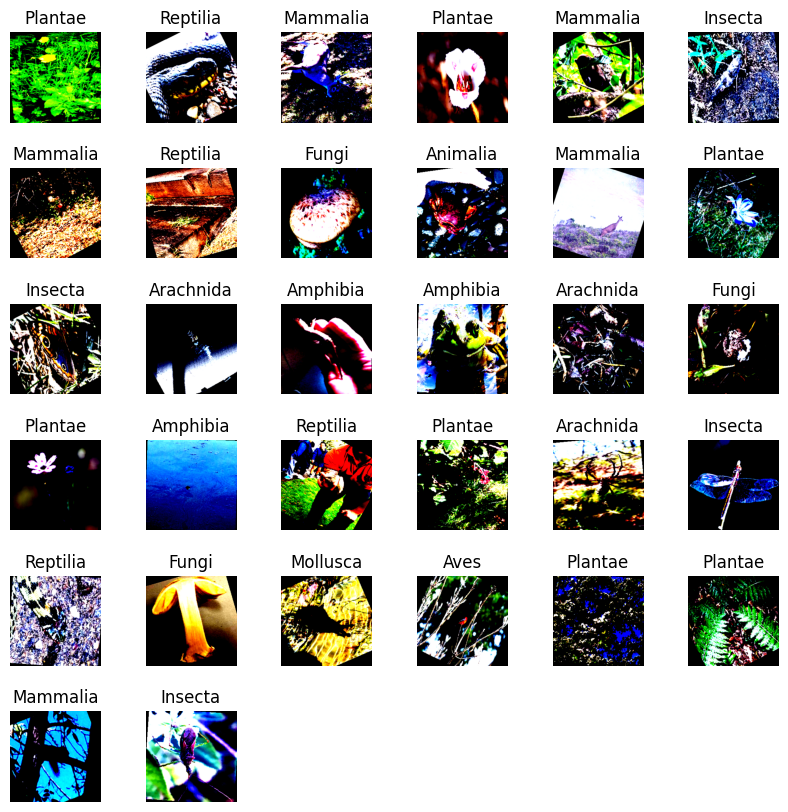

In [ ]:
for images, labels in train_loader:
  show_images(images, labels)
  break